# LDE Project

In [26]:
# packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import json
import pandas as pd
import seaborn as sn

In [27]:
"""
# QUESTO ERA IL MODELLO IN CUI FACEVAMO PARTIRE IL LOCKDOWN AL 17G
# lockdown effect

def myrate(t, r):
    if t>=17:    #from the 17th day
        return r
    else:
        return 1
    
def mymodel(t, z, beta, mu, gamma, fD, delta_c, k, nu, r):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k)
    dE = beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H  #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H  
    return [dS, dE, dI, dR, dH, dD]


# QUESTO ERA IL MODELLO CON DUE STEP DI LOCKDOWN
# two-step lockdown

def two_rate(t, r1, r2):
    if t>=17 and t<28:
        return r1
    elif t>=28:
        return r2
    else:
        return 1

def twostep_model(t, z, beta, mu, gamma, fD, delta_c, k, nu, r1, r2):
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*two_rate(t, r1, r2)/(1+(dD/delta_c)**k)
    dE = beta*S*I*two_rate(t, r1, r2)/(1+(dD/delta_c)**k) - mu*E
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H
    dH = fD*gamma*I - gamma_H*H      
    return [dS, dE, dI, dR, dH, dD]"""

"\n# QUESTO ERA IL MODELLO IN CUI FACEVAMO PARTIRE IL LOCKDOWN AL 17G\n# lockdown effect\n\ndef myrate(t, r):\n    if t>=17:    #from the 17th day\n        return r\n    else:\n        return 1\n    \ndef mymodel(t, z, beta, mu, gamma, fD, delta_c, k, nu, r):\n    S, E, I, R, H, D = z\n    dD = gamma_H*nu*H\n    dS = -beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k)\n    dE = beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k) - mu*E \n    dI = mu*E - gamma*I\n    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H  #nu non c'era nel weitz, da H a R\n    dH = fD*gamma*I - gamma_H*H  \n    return [dS, dE, dI, dR, dH, dD]\n\n\n# QUESTO ERA IL MODELLO CON DUE STEP DI LOCKDOWN\n# two-step lockdown\n\ndef two_rate(t, r1, r2):\n    if t>=17 and t<28:\n        return r1\n    elif t>=28:\n        return r2\n    else:\n        return 1\n\ndef twostep_model(t, z, beta, mu, gamma, fD, delta_c, k, nu, r1, r2):\n    S, E, I, R, H, D = z\n    dD = gamma_H*nu*H\n    dS = -beta*S*I*two_rate(t, r1, r2)/(1+(dD/delta_c)**k)\n    dE =

In [28]:
# 1) permanent lockdown after reaching the threshold the first time

def myrate_hosp(t, r, t_thrsld):
    if t>=t_thrsld:    
        return r
    else:
        return 1
    
def mymodel_hosp(t, z, beta, mu, gamma, fD, delta_c, k, nu, r, thrsld, t_thrsld):
    
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k)
    dE = beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H  #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H
    
    return [dS, dE, dI, dR, dH, dD]

In [29]:
# 2) long term fear

def long_term_fear(t, z, beta, mu, gamma, fD, delta_c, D_c, k, nu, r, t_thrsld):
    
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k + (D/D_c)**k)
    dE = beta*S*I*myrate_hosp(t, r, t_thrsld)/(1+(dD/delta_c)**k + (D/D_c)**k) - mu*E 
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H   #nu non c'era nel weitz, da H a R
    dH = fD*gamma*I - gamma_H*H  
    
    return [dS, dE, dI, dR, dH, dD]

In [30]:
# 3) intermittent lockdown when reaching the threshold

def lockdown(H, t,  r1, r2, thrsld):
    
    if t > 0:
        if H > thrsld:
            return r1
        else:
            return r2
    else: 
        return 1

def lockdown_model(t, z, beta, mu, gamma, fD, delta_c, k, nu, r1, r2, thrsld):
    
    S, E, I, R, H, D = z
    dD = gamma_H*nu*H
    dS = -beta*S*I*lockdown(H, t,  r1, r2, thrsld)/(1+(dD/delta_c)**k)
    dE = beta*S*I*lockdown(H, t, r1, r2, thrsld)/(1+(dD/delta_c)**k) - mu*E
    dI = mu*E - gamma*I
    dR = (1-fD)*gamma*I + gamma_H*(1-nu)*H
    dH = fD*gamma*I - gamma_H*H      
    
    return [dS, dE, dI, dR, dH, dD]

In [31]:
# model parameters
R_0 = 3.49
mu = 1/2      #(mean latency period)^-1
gamma = 1/6   #(mean infectious period)^-1
beta = R_0 * gamma
gamma_H = 1/10   # (mean hospital stay)^-1
fD = 0.08
k = 1
nu = 3239/6909 #ratio from H to D n(D/H)/n(H)=3239/6909 section 3.1 April
r = 0.31
r1 = 0.31
r2 = 0.26
delta_c = (50/60)*1e-6
D_c = 5e3/(60e6)
N = 60*1e6

# initial situation in Italy
S0 = 60.352*1e6
E0 = 1695
I0 = 308.8
R0 = 311.1
H0 = 127.4
D0 = 0
N0 = E0+I0+H0+R0+S0

thrsld = 1e-5*S0/N0

z0 = np.array([S0, E0, I0, R0, H0, D0])/N0

## awareness/no awareness

In [32]:
t_max=250
t = np.arange(t_max)

# 1) PERMANENT LOCKDOWN
#at first, we look for time instant at which the hospitalized threshold for
#lockdown is reached, then we use it in a permanent lockdown model
t_thrsld=t_max+1
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, 1, thrsld, t_thrsld))

S, E, I, R, H, D = sol.sol(t)
x = [S, E, I, R, H, D]

index = 0
for i, h in enumerate(H):
    if (h>thrsld): 
        index=i
        break
        
t_thrsld = index    
sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, thrsld, t_thrsld))

S, E, I, R, H, D = sol.sol(t)
x = [S, E, I, R, H, D]


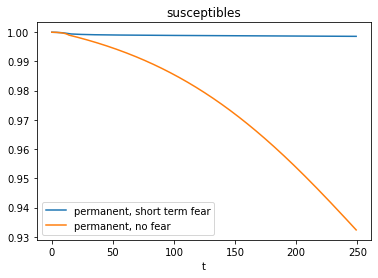

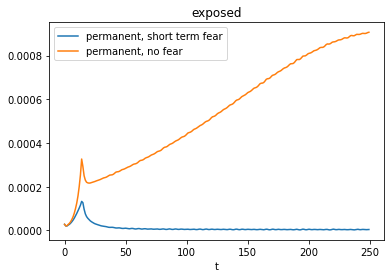

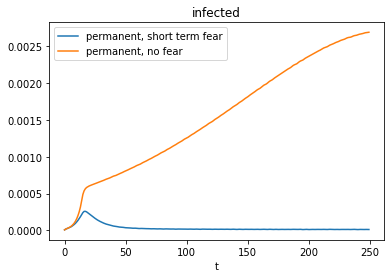

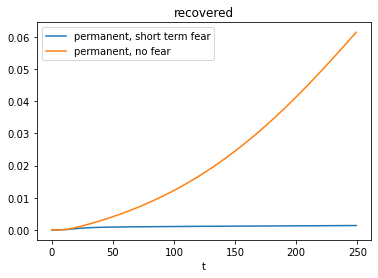

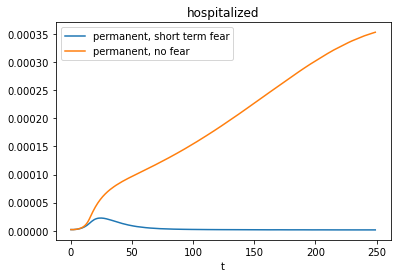

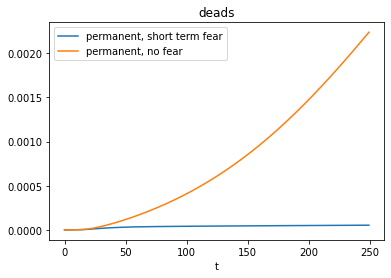

In [40]:
# no fear -> delta_c=10000
sol1 = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 10000, k, nu, r, thrsld, t_thrsld))

S1, E1, I1, R1, H1, D1 = sol1.sol(t)
x1 = [S1, E1, I1, R1, H1, D1]

names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col1) in enumerate(zip(x, x1)):
    plt.figure(i)
    plt.plot(t, col.T, label = 'permanent, short term fear')
    plt.plot(t, col1.T, label = 'permanent, no fear')
    plt.xlabel('t')
    plt.legend()
    plt.title(names[i])

In [34]:
#sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r))
#sol2 = solve_ivp(twostep_model, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r1,r2))
#S, E, I, R, H, D = sol.sol(t)
#S2, E2, I2, R2, H2, D2 = sol2.sol(t)
#x = [S, E, I, R, H, D]
#x2 = [S2, E2, I2, R2, H2, D2]

## short/long term awareness

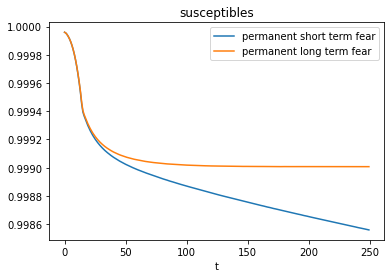

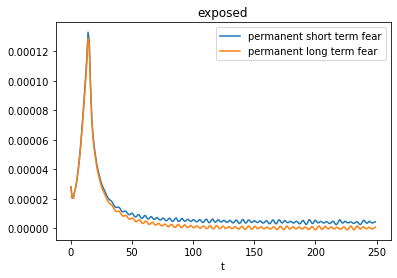

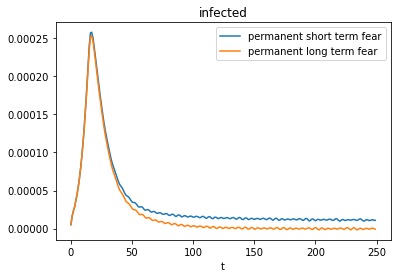

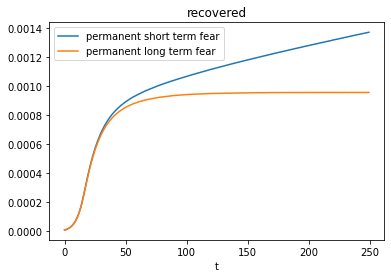

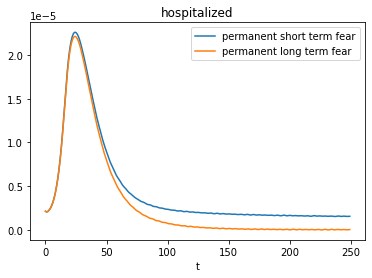

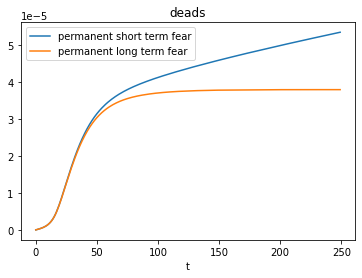

In [35]:
# 2) LONG TERM AWARENESS
sol2 = solve_ivp(long_term_fear, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, D_c, k, nu, r, t_thrsld))

S2, E2, I2, R2, H2, D2 = sol2.sol(t)
x2 = [S2, E2, I2, R2, H2, D2 ]

names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col2) in enumerate(zip(x, x2)):
    plt.figure(i)
    plt.plot(t, col.T, label = 'permanent short term fear')
    plt.plot(t, col2.T, label = 'permanent long term fear')
    plt.xlabel('t')
    plt.legend()
    plt.title(names[i])

## permanent/intermittent lockdown

!!!\
Nel modello del lockdown intermittente c'è il problema che prima di raggiungere la soglia la prima volta r=r2=0.65 invece che r=1. \
Di seguito impostiamo r2=1.\
!!!

In [36]:
# 3) INTERMITTENT LOCKDOWN
sol3 = solve_ivp(lockdown_model, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, 0.31, 1, thrsld))

S3, E3, I3, R3, H3, D3 = sol3.sol(t)
x3 = [S3, E3, I3, R3, H3, D3]


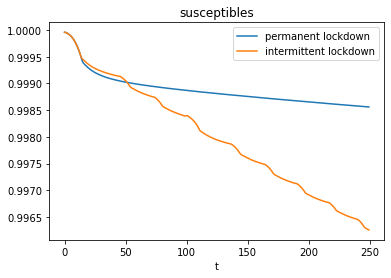

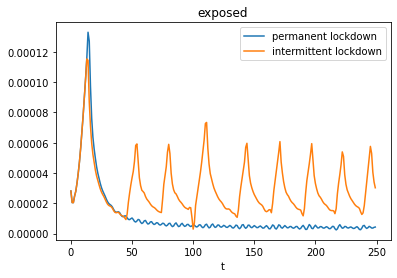

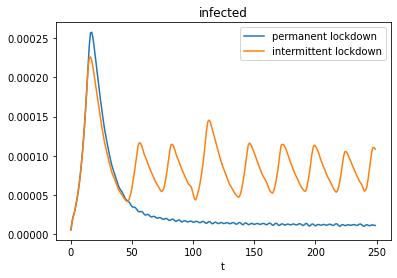

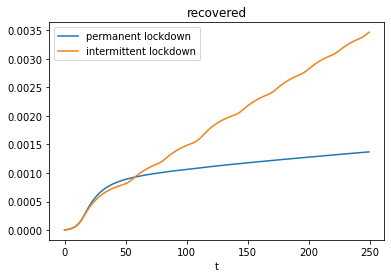

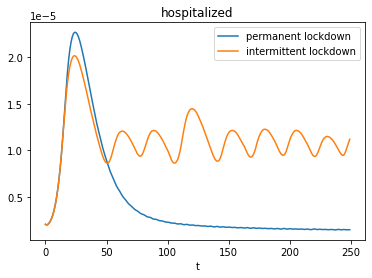

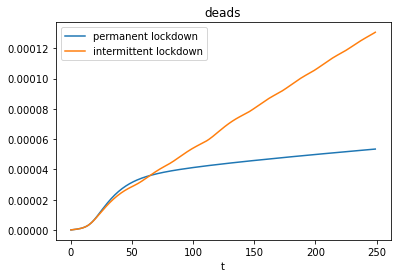

In [37]:
for i,(col,col3) in enumerate(zip(x, x3)):
    plt.figure(i)
    plt.plot(t, col.T, label = 'permanent lockdown')
    plt.plot(t, col3.T, label = 'intermittent lockdown')
    plt.xlabel('t')
    plt.legend()
    plt.title(names[i])

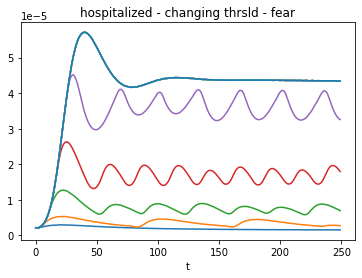

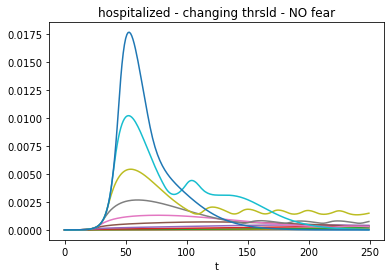

In [38]:
# change threshold
thrsld_vctr = np.logspace(-6, -2, 11)

Hs = np.zeros(shape=(11, t_max))
Hs1 = np.zeros(shape=(11, t_max))

for i,thrsld in enumerate(thrsld_vctr):
    # with fear
    sol = solve_ivp(lockdown_model, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu,  0.31, 1, thrsld))
    # without fear
    sol1 = solve_ivp(lockdown_model, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 1000, k, nu,  0.31, 1, thrsld))
    S, E, I, R, H, D = sol.sol(t)
    S1, E1, I1, R1, H1, D1 = sol1.sol(t)
    Hs[i,:]=H
    Hs1[i,:]=H1
    
plt.plot(t,Hs.T)
plt.title('hospitalized - changing thrsld - fear')
plt.xlabel('t')
plt.show()
plt.plot(t,Hs1.T)
plt.title('hospitalized - changing thrsld - NO fear')
plt.xlabel('t')
plt.show()

Con paura non si va oltre 10^-5, quindi lockdown non scatta, ma vediamo il plateau\
Senza paura la dinamica è libera e spazia su diversi ordini di grandezza che vengono smorzati dal relativo lockdown

In [13]:
"""# total population plot
N = N0*(S+E+I+R+H)
N2 = N0*(S2+E2+I2+R2+H2)

plt.plot(t,N,label='1 step')
plt.plot(t,N2,label='2 step')
plt.title('total population')
plt.xlabel('t')
plt.legend()
plt.show()"""

"# total population plot\nN = N0*(S+E+I+R+H)\nN2 = N0*(S2+E2+I2+R2+H2)\n\nplt.plot(t,N,label='1 step')\nplt.plot(t,N2,label='2 step')\nplt.title('total population')\nplt.xlabel('t')\nplt.legend()\nplt.show()"

## Parameter space: rate & $\delta_c$

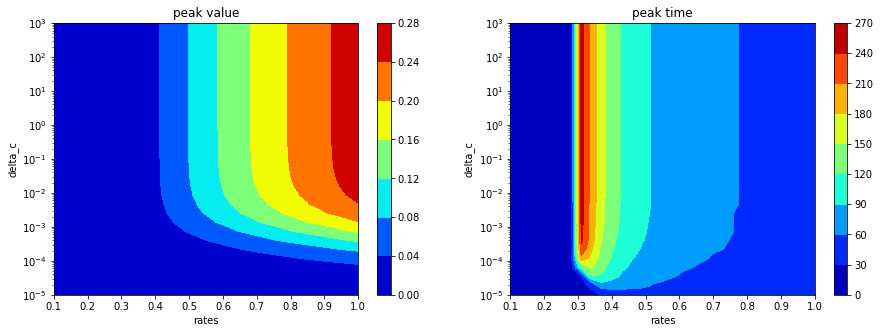

In [14]:
# change: rates & delta_c
# look at: peak values & peak times

t_max = 250
t = np.arange(t_max)

delta_c = np.logspace(-5, 3, 31) #101 PUNTI PER PLOT PIù FINE
rates = np.linspace(0.1, 1, 31)

peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, r, thrsld, t_thrsld))
        #sol = solve_ivp(mymodel, [0, t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, r))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value
        
# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(rates, delta_c)   

f1 = ax1.contourf(X, Y, peak_values,cmap='jet')
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('delta_c')
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times,cmap='jet')
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('delta_c')
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
plt.show()

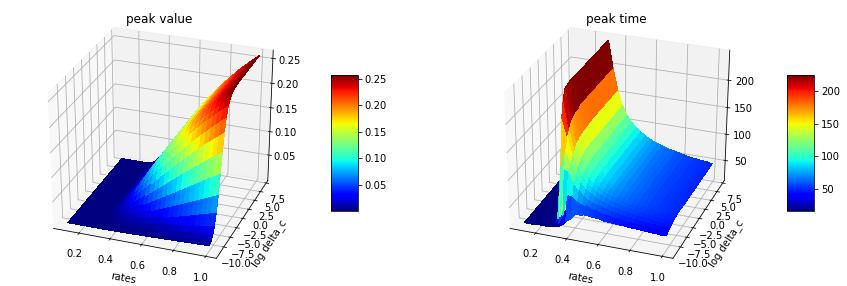

In [15]:
# 3D plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, np.log(Y), peak_values, cmap='jet',linewidth=0, antialiased=False)
ax1.view_init(30, 290)  #230
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('log delta_c')

surf2 = ax2.plot_surface(X, np.log(Y), peak_times, cmap='jet',linewidth=0, antialiased=False)
ax2.view_init(30, 290)
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('log delta_c')

fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
plt.show()

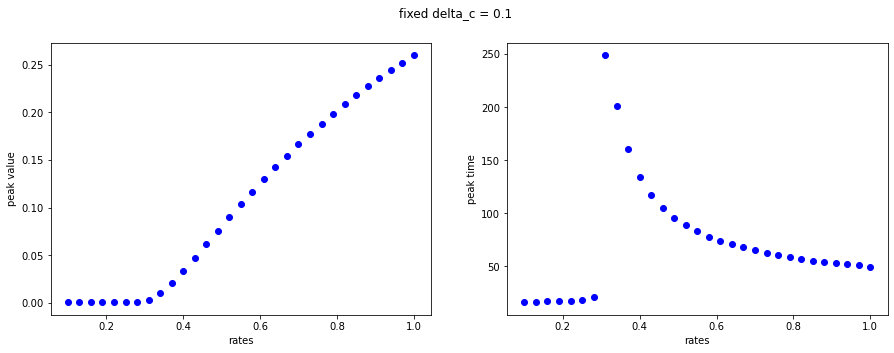

In [16]:
# fixed delta_c
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(rates, peak_values[15,:], 'bo')
ax1.set_xlabel('rates')
ax1.set_ylabel('peak value')

ax2.plot(rates, peak_times[15,:], 'bo')
ax2.set_xlabel('rates')
ax2.set_ylabel('peak time')

fig.suptitle('fixed delta_c = 0.1')
plt.show()

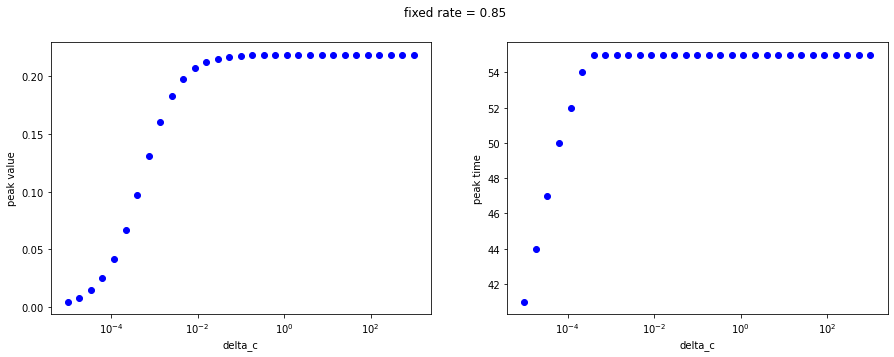

In [17]:
# fixed rate
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

ax1.plot(delta_c, peak_values[:,25], 'bo')
ax1.set_xscale('log')
ax1.set_xlabel('delta_c')
ax1.set_ylabel('peak value')

ax2.plot(delta_c, peak_times[:,25], 'bo')
ax2.set_xscale('log')
ax2.set_xlabel('delta_c')
ax2.set_ylabel('peak time')

fig.suptitle('fixed rate = 0.85')
plt.show()

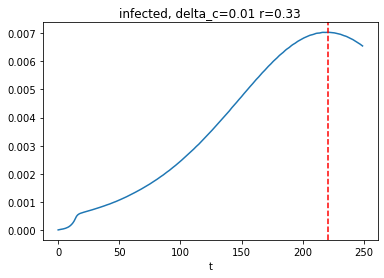

In [18]:
# example of infected dynamics

sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 1e-2, k, nu, 0.33, thrsld, t_thrsld))
#sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, 1e-2, k, nu, 0.33))
t = np.arange(t_max)
S, E, I, R, H, D = sol.sol(t)
peak_time = np.argmax(I)
peak_time

# plot
plt.plot(t,I)
plt.axvline(peak_time, color='r', linestyle='--',label='peak')
plt.title('infected, delta_c=0.01 r=0.33')
plt.xlabel('t')
plt.show()

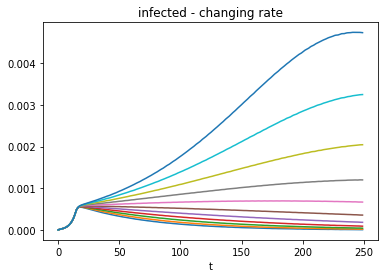

In [19]:
# infected dynamics
# changing rates

delta_c = 1e-1
rates = np.linspace(0.25, 0.32, 11)

Is = np.zeros(shape=(11, t_max))
for i,r in enumerate(rates):
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, thrsld, t_thrsld))
    #sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing rate')
plt.show()

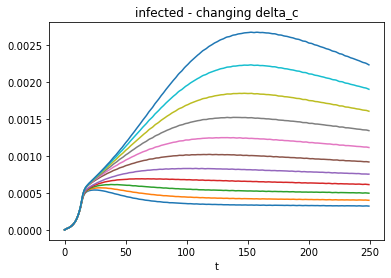

In [20]:
# infected dynamics
# changing delta_c

delta_c = np.logspace(-5, -4, 11)
rates = 0.35

Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, rates, thrsld, t_thrsld))
    #sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, rates))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing delta_c')
plt.show()

## Parameter $k = 4$

In [21]:
k1 = 4

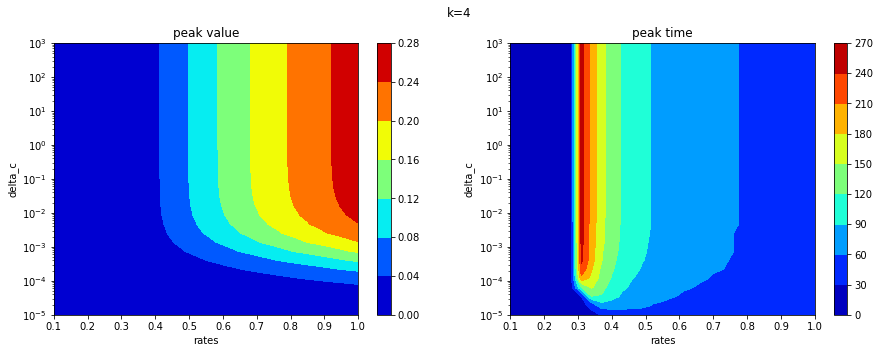

In [22]:
# change: rates & delta_c
# look at: peak values & peak times

t_max = 250
t = np.arange(t_max)

delta_c = np.logspace(-5, 3, 31)
rates = np.linspace(0.1, 1, 31)

peak_times = np.zeros((len(delta_c), len(rates)))
peak_values = np.zeros((len(delta_c), len(rates)))

for i, delta in enumerate(delta_c):
    for j, r in enumerate(rates):
        sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k, nu, r, thrsld, t_thrsld))
        #sol = solve_ivp(mymodel, [0, t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k1, nu, r))
        S, E, I, R, H, D = sol.sol(t)
        peak_time = np.argmax(I)
        peak_value = np.max(I)
        peak_times[i, j] = peak_time
        peak_values[i, j] = peak_value

# plots
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

X, Y = np.meshgrid(rates, delta_c)   

f1 = ax1.contourf(X, Y, peak_values, cmap='jet')
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('delta_c')
ax1.set_yscale('log')

f2 = ax2.contourf(X, Y, peak_times, cmap='jet')
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('delta_c')
ax2.set_yscale('log')

fig.colorbar(f1, ax=ax1)
fig.colorbar(f2, ax=ax2)
fig.suptitle('k=4')
plt.show()

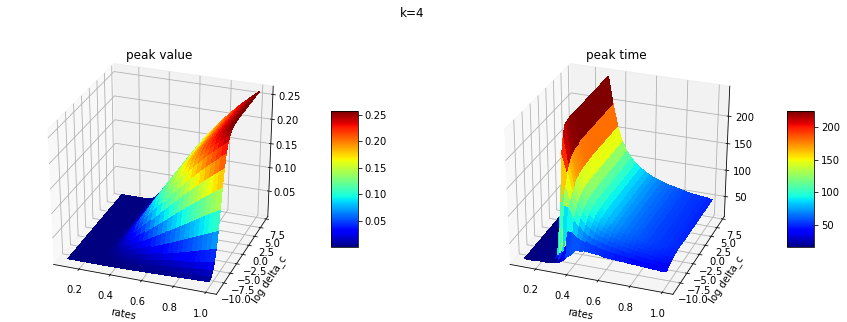

In [23]:
# 3D plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5),subplot_kw={"projection": "3d"})

surf1 = ax1.plot_surface(X, np.log(Y), peak_values, cmap='jet',linewidth=0, antialiased=False)
ax1.view_init(30, 290)  #230
ax1.set_title('peak value')
ax1.set_xlabel('rates')
ax1.set_ylabel('log delta_c')

surf2 = ax2.plot_surface(X, np.log(Y), peak_times, cmap='jet',linewidth=0, antialiased=False)
ax2.view_init(30, 290)
ax2.set_title('peak time')
ax2.set_xlabel('rates')
ax2.set_ylabel('log delta_c')

fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
fig.suptitle('k=4')
plt.show()

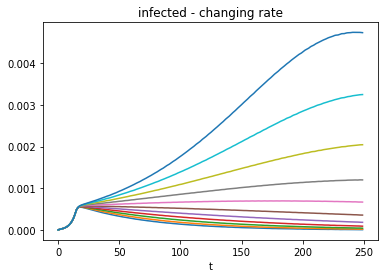

In [24]:
# infected dynamics
# changing rates

delta_c = 1e-1
rates = np.linspace(0.25, 0.32, 11)

Is = np.zeros(shape=(11, t_max))
for i,r in enumerate(rates):
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r, thrsld, t_thrsld))
    #sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k1, nu, r))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing rate')
plt.show()

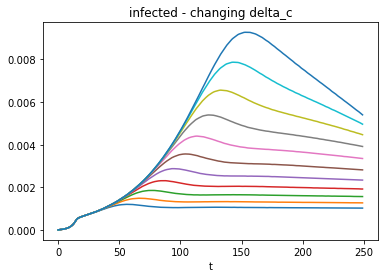

In [25]:
# infected dynamics
# changing delta_c

delta_c = np.logspace(-5, -4, 11)
rates = 0.35

Is = np.zeros(shape=(11, t_max))
for i,delta in enumerate(delta_c):
    sol = solve_ivp(mymodel_hosp, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k1, nu, rates, thrsld, t_thrsld))
    #sol = solve_ivp(mymodel, [0,t_max], z0, dense_output=True, args=(beta, mu, gamma, fD, delta, k1, nu, rates))
    S, E, I, R, H, D = sol.sol(t)
    Is[i,:]=I
    
plt.plot(t,Is.T)
plt.xlabel('t')
plt.title('infected - changing delta_c')
plt.show()